<a href="https://colab.research.google.com/github/Thibault13320/machine-learning-zoomcamp/blob/main/04-evaluation/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [83]:
# ============================================================================
# DATA LOADING AND PREPARATION
# ============================================================================

# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
print(f"Chargement des données depuis: {url}\n")
df = pd.read_csv(url)

Chargement des données depuis: https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv



In [84]:
print("="*80)
print("EXPLORATION INITIALE DES DONNÉES")
print("="*80)
print(f"Forme du dataset: {df.shape}")
print(f"\nNoms des colonnes: {df.columns.tolist()}")
print(f"\nPremières lignes:\n{df.head()}")
print(f"\nDistribution de la variable cible 'converted':\n{df['converted'].value_counts()}")
print(f"Taux de conversion: {df['converted'].mean():.3f}")

EXPLORATION INITIALE DES DONNÉES
Forme du dataset: (1462, 9)

Noms des colonnes: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

Premières lignes:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1

In [85]:
# DATA PREPARATION
print("\n" + "="*80)
print("PRÉPARATION DES DONNÉES")
print("="*80)

print("\nValeurs manquantes AVANT traitement:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])


PRÉPARATION DES DONNÉES

Valeurs manquantes AVANT traitement:
lead_source          128
industry             134
annual_income        181
employment_status    100
location              63
dtype: int64


In [5]:
# Handle missing values
# For categorical features: replace with 'NA'
# For numerical features: replace with 0.0

In [86]:
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numerical_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

print(f"\nColonnes catégorielles: {categorical_cols}")
print(f"Colonnes numériques: {numerical_cols}")



Colonnes catégorielles: ['lead_source', 'industry', 'employment_status', 'location']
Colonnes numériques: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [88]:
# Filling out the missing values
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

print("\nValues missing after processing:")
print(df.isnull().sum().sum(), "Value missing in total")


Values missing after processing:
0 Value missing in total


In [89]:
# Split: 60% train, 20% validation, 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

print(f"\nTaille des ensembles:")
print(f"Train: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")



Taille des ensembles:
Train: 876 (59.9%)
Validation: 293 (20.0%)
Test: 293 (20.0%)


In [11]:
print("\n" + "="*80)
print("QUESTION 1: ROC AUC Feature Importance")
print("="*80)


QUESTION 1: ROC AUC Feature Importance


In [110]:
features_to_test = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
y_train = df_train['converted'].values
auc_scores = {}

for feature in features_to_test:
    score = df_train[feature].values
    auc = roc_auc_score(y_train, score)

    # If AUC < 0.5, inversed the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f"{feature:30s}: {auc:.4f} (inversé)")
    else:
        print(f"{feature:30s}: {auc:.4f}")

    auc_scores[feature] = auc

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\n>>> RÉPONSE Q1: '{best_feature}'")

lead_score                    : 0.6145
number_of_courses_viewed      : 0.7636
interaction_count             : 0.7383
annual_income                 : 0.5520

>>> RÉPONSE Q1: 'number_of_courses_viewed'


In [19]:
print("\n" + "="*80)
print("QUESTION 2: Training the Model")
print("="*80)



QUESTION 2: Training the Model


In [112]:
# Prepare data
def prepare_data(df):
    """Convert the dataframe in dictionnary format for DictVectorizer"""
    df_dict = df.drop('converted', axis=1).to_dict(orient='records')
    return df_dict

train_dicts = prepare_data(df_train)
val_dicts = prepare_data(df_val)

In [115]:
# One-hot encoding avec DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train['converted'].values
y_val = df_val['converted'].values

print(f"Ensemble d'entraînement: X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Ensemble de validation: X shape = {X_val.shape}, y shape = {y_val.shape}")
print(f"Nombre de features après one-hot encoding: {X_train.shape[1]}")

Ensemble d'entraînement: X shape = (876, 31), y shape = (876,)
Ensemble de validation: X shape = (293, 31), y shape = (293,)
Nombre de features après one-hot encoding: 31


In [116]:
# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_val_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_val = roc_auc_score(y_val, y_val_pred)
print(f"\n>>> RÉPONSE Q2: AUC sur validation = {auc_val:.3f}")


>>> RÉPONSE Q2: AUC sur validation = 0.817


In [25]:
# Predict on validation set
y_val_pred = model.predict_proba(X_val)[:, 1]

In [26]:
# Calculate AUC
auc_val = roc_auc_score(y_val, y_val_pred)
print(f"\nAUC on validation dataset: {auc_val:.3f}")
print(f"Answer Q2: {auc_val:.3f}")


AUC on validation dataset: 0.817
Answer Q2: 0.817


In [27]:
print("\n" + "="*80)
print("QUESTION 3: Precision and Recall")
print("="*80)


QUESTION 3: Precision and Recall


In [141]:
# Evaluate precision and recall for different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_threshold = (y_val_pred >= threshold).astype(int)

    # Calculate precision and recall
    if y_pred_threshold.sum() == 0:
        precision = 0
    else:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)

    recall = recall_score(y_val, y_pred_threshold, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)

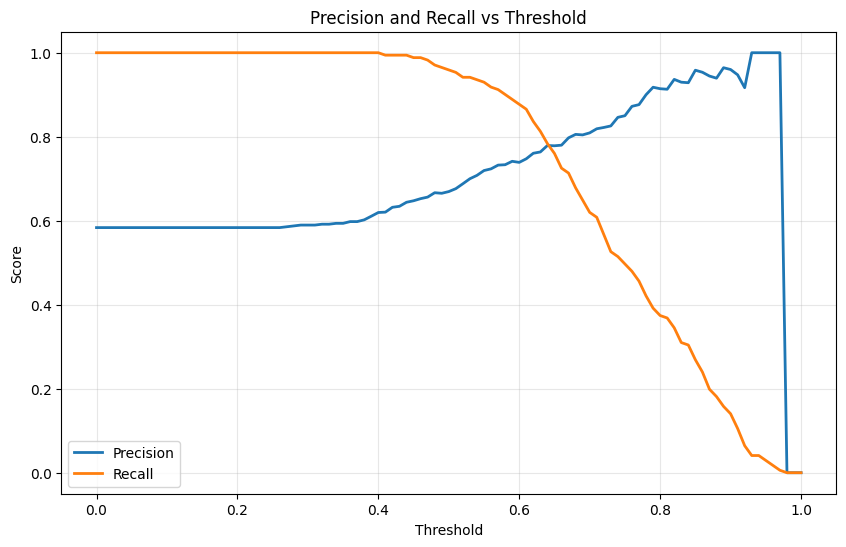

In [142]:
# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [143]:
# Find intersection point
precisions_arr = np.array(precisions)
recalls_arr = np.array(recalls)


In [144]:
# Only consider thresholds where BOTH precision and recall are greater than 0
# This avoids meaningless intersections at extreme thresholds
valid_mask = (precisions_arr > 0) & (recalls_arr > 0)
valid_thresholds = thresholds[valid_mask]
valid_precisions = precisions_arr[valid_mask]
valid_recalls = recalls_arr[valid_mask]

In [145]:
# Calculate absolute differences for valid points only
valid_differences = np.abs(valid_precisions - valid_recalls)


In [146]:
# Find all local minima (potential intersection points)
print("\nTop 10 closest precision-recall points (with non-zero values):")
sorted_indices = np.argsort(valid_differences)[:10]
for idx in sorted_indices:
    print(f"Threshold: {valid_thresholds[idx]:.3f}, Precision: {valid_precisions[idx]:.3f}, Recall: {valid_recalls[idx]:.3f}, Diff: {valid_differences[idx]:.4f}")



Top 10 closest precision-recall points (with non-zero values):
Threshold: 0.640, Precision: 0.779, Recall: 0.784, Diff: 0.0046
Threshold: 0.650, Precision: 0.778, Recall: 0.760, Diff: 0.0182
Threshold: 0.630, Precision: 0.764, Recall: 0.813, Diff: 0.0491
Threshold: 0.660, Precision: 0.780, Recall: 0.725, Diff: 0.0547
Threshold: 0.620, Precision: 0.761, Recall: 0.836, Diff: 0.0756
Threshold: 0.670, Precision: 0.797, Recall: 0.713, Diff: 0.0839
Threshold: 0.610, Precision: 0.747, Recall: 0.865, Diff: 0.1180
Threshold: 0.680, Precision: 0.806, Recall: 0.678, Diff: 0.1272
Threshold: 0.600, Precision: 0.739, Recall: 0.877, Diff: 0.1383
Threshold: 0.590, Precision: 0.741, Recall: 0.889, Diff: 0.1474


In [147]:
# Find the threshold with minimum difference among valid points
intersection_idx = np.argmin(valid_differences)
intersection_threshold = valid_thresholds[intersection_idx]
intersection_precision = valid_precisions[intersection_idx]
intersection_recall = valid_recalls[intersection_idx]

print(f"\nPrecision and Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"At this threshold:")
print(f"  Precision: {intersection_precision:.3f}")
print(f"  Recall: {intersection_recall:.3f}")
print(f"  Difference: {valid_differences[intersection_idx]:.4f}")
print(f"\n>>> ANSWER Q3: {intersection_threshold:.3f}")


Precision and Recall intersect at threshold: 0.640
At this threshold:
  Precision: 0.779
  Recall: 0.784
  Difference: 0.0046

>>> ANSWER Q3: 0.640


In [41]:
print("\n" + "="*80)
print("QUESTION 4: F1 Score")
print("="*80)



QUESTION 4: F1 Score


In [148]:
# Calculate F1 score for all thresholds
f1_scores = []

for i, threshold in enumerate(thresholds):
    P = precisions[i]
    R = recalls[i]

    # Calculate F1 score (handle division by zero)
    if P + R == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)

    f1_scores.append(f1)

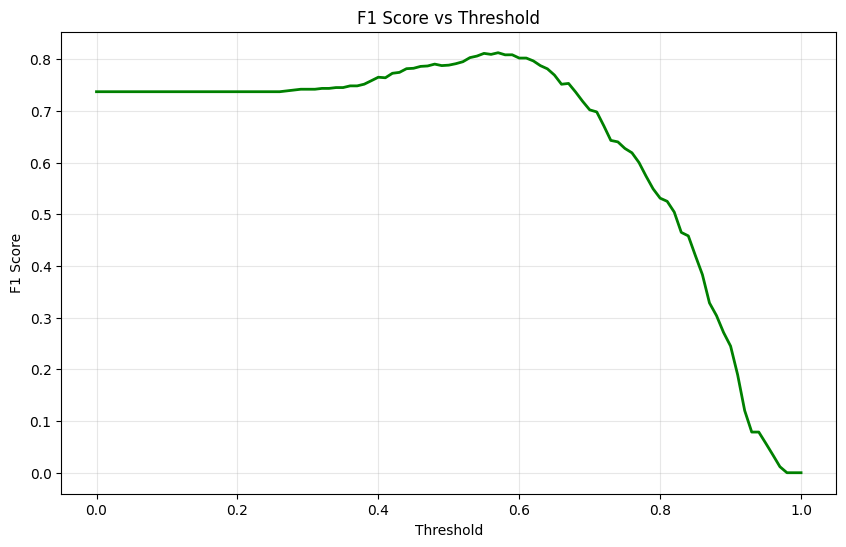

In [149]:
# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True, alpha=0.3)
plt.show()

In [150]:
# Find threshold with maximum F1
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"\nMaximum F1 score: {max_f1_value:.4f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")
print(f"\n>>> ANSWER Q4: {max_f1_threshold:.2f}")


Maximum F1 score: 0.8125
Threshold at maximum F1: 0.57

>>> ANSWER Q4: 0.57


In [45]:
print("\n" + "="*80)
print("QUESTION 5: 5-Fold Cross-Validation")
print("="*80)


QUESTION 5: 5-Fold Cross-Validation


In [155]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_cv = []

In [156]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    df_fold_train = df_full_train.iloc[train_idx]
    df_fold_val = df_full_train.iloc[val_idx]

    fold_train_dicts = prepare_data(df_fold_train)
    fold_val_dicts = prepare_data(df_fold_val)

    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(fold_train_dicts)
    X_fold_val = dv_fold.transform(fold_val_dicts)

    y_fold_train = df_fold_train['converted'].values
    y_fold_val = df_fold_val['converted'].values

    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)

    y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_fold_pred)

    auc_scores_cv.append(auc_fold)
    print(f"Fold {fold + 1}: AUC = {auc_fold:.4f}")

std_auc = np.std(auc_scores_cv)
std_auc_sample = np.std(auc_scores_cv, ddof=1)
mean_auc = np.mean(auc_scores_cv)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Standard deviation (population, ddof=0): {std_auc:.4f}")
print(f"Standard deviation (sample, ddof=1): {std_auc_sample:.4f}")
print(f"\n>>> ANSWER Q5: {std_auc:.4f}")

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard deviation (population, ddof=0): 0.0358
Standard deviation (sample, ddof=1): 0.0400

>>> ANSWER Q5: 0.0358


In [157]:
print("\n" + "="*80)
print("QUESTION 6: Hyperparameter Tuning")
print("="*80)



QUESTION 6: Hyperparameter Tuning


In [158]:
C_values = [0.000001, 0.001, 1]
results = {}

In [159]:
for C in C_values:
    print(f"\nTesting C = {C}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores_c = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]
        fold_train_dicts = prepare_data(df_fold_train)
        fold_val_dicts = prepare_data(df_fold_val)
        dv_fold = DictVectorizer(sparse=False)
        X_fold_train = dv_fold.fit_transform(fold_train_dicts)
        X_fold_val = dv_fold.transform(fold_val_dicts)
        y_fold_train = df_fold_train['converted'].values
        y_fold_val = df_fold_val['converted'].values
        model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_c.fit(X_fold_train, y_fold_train)
        y_fold_pred = model_c.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
        auc_scores_c.append(auc_fold)
    mean_auc_c = np.mean(auc_scores_c)
    std_auc_c = np.std(auc_scores_c)
    results[C] = {'mean': round(mean_auc_c, 3), 'std': round(std_auc_c, 3)}
    print(f"  Mean AUC: {results[C]['mean']:.3f}")
    print(f"  Std AUC: {results[C]['std']:.3f}")


Testing C = 1e-06
  Mean AUC: 0.560
  Std AUC: 0.024

Testing C = 0.001
  Mean AUC: 0.867
  Std AUC: 0.029

Testing C = 1
  Mean AUC: 0.822
  Std AUC: 0.036


In [160]:
print("\n" + "-"*50)
print("SUMMARY OF RESULTS:")
print("-"*50)
for C in C_values:
    print(f"C = {C:9.6f}: Mean = {results[C]['mean']:.3f}, Std = {results[C]['std']:.3f}")

best_C = max(C_values, key=lambda c: (results[c]['mean'], -results[c]['std'], -c))
print(f"\nAnswer Q6: C = {best_C} leads to the best mean score")
print(f"Best result: Mean = {results[best_C]['mean']:.3f}, Std = {results[best_C]['std']:.3f}")




--------------------------------------------------
SUMMARY OF RESULTS:
--------------------------------------------------
C =  0.000001: Mean = 0.560, Std = 0.024
C =  0.001000: Mean = 0.867, Std = 0.029
C =  1.000000: Mean = 0.822, Std = 0.036

Answer Q6: C = 0.001 leads to the best mean score
Best result: Mean = 0.867, Std = 0.029


In [162]:
# FINAL SUMMARY
print("\n" + "="*80)
print("FINAL ANSWERS SUMMARY")
print("="*80)
print(f"Q1: Feature with highest AUC - {best_feature}")
print(f"Q2: AUC on validation - {auc_val:.3f}")
print(f"Q3: Precision-Recall intersection - {intersection_threshold:.3f}")
print(f"Q4: Threshold at max F1 - {max_f1_threshold:.2f}")
print(f"Q5: Std deviation of CV scores - {std_auc:.4f}")
print(f"Q6: Best C value - {best_C}")
print("="*80)


FINAL ANSWERS SUMMARY
Q1: Feature with highest AUC - number_of_courses_viewed
Q2: AUC on validation - 0.817
Q3: Precision-Recall intersection - 0.640
Q4: Threshold at max F1 - 0.57
Q5: Std deviation of CV scores - 0.0358
Q6: Best C value - 0.001
